In [1]:

!pip install scikit-learn transformers torch pandas




  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl.metadata (1.8 kB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinu

In [23]:
import numpy as np
import pandas as pd
from transformers import TrainerCallback, TrainerState, TrainerControl, get_linear_schedule_with_warmup
from transformers import BertForSequenceClassification, BertTokenizer, Trainer, TrainingArguments
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report

from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import os
from transformers import AdamW, get_linear_schedule_with_warmup

In [3]:
# !fusermount -u /content/drive

from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [4]:
# Check if GPU is available
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

print(f'Using device: {device}')

Using device: cuda


In [24]:
# functions and classes

def encode_labels(data, column_name):
    """
    Encode the categorical labels into numerical labels using LabelEncoder.

    Args:
    - data (pd.DataFrame): The dataset containing the categorical column.
    - column_name (str): The name of the column to encode.

    Returns:
    - y (np.array): The encoded labels.
    - label_mapping (dict): A dictionary mapping the actual labels to encoded labels.
    - label_encoder (LabelEncoder): The fitted LabelEncoder instance for decoding.
    """
    # Initialize the LabelEncoder
    label_encoder = LabelEncoder()

    # Fit the LabelEncoder and transform the specified column into numerical labels
    y = label_encoder.fit_transform(data[column_name])

    # Get the mapping of labels to their encoded values
    label_mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))

    # Print the mapping
    print("Mapping of actual labels to encoded labels:")
    for label, encoded_label in label_mapping.items():
        print(f"'{label}': {encoded_label}")

    return y, label_mapping, label_encoder

def decode_labels(predicted_labels, label_encoder):
    """
    Decode numerical labels back to their original categorical labels.

    Args:
    - predicted_labels (np.array): The predicted numerical labels.
    - label_encoder (LabelEncoder): The fitted LabelEncoder instance.

    Returns:
    - decoded_labels (np.array): The decoded original labels.
    """
    return label_encoder.inverse_transform(predicted_labels)


In [25]:
def stratified_split(data, target, feature_column, train_size=0.7, val_size=0.15, test_size=0.15, random_state=42):
    """
    Perform a stratified split of the data into training, validation, and test sets.

    Args:
    - data (pd.DataFrame): The dataset containing the features.
    - target (np.array): The target labels.
    - feature_column (str): The name of the column to use as features.
    - train_size (float): Proportion of the data to include in the training set (default is 0.7).
    - val_size (float): Proportion of the data to include in the validation set (default is 0.15).
    - test_size (float): Proportion of the data to include in the test set (default is 0.15).
    - random_state (int): Seed used by the random number generator (default is 42).

    Returns:
    - X_train, X_val, X_test: Features for the training, validation, and test sets.
    - y_train, y_val, y_test: Labels for the training, validation, and test sets.
    """
    # Step 1: Define features
    X = data[feature_column]

    # Step 2: Perform Stratified Split
    # First split: train and temp (70% train, 30% temp)
    X_train, X_temp, y_train, y_temp = train_test_split(X, target, test_size=(1 - train_size), stratify=target, random_state=random_state)

    # Second split: Split the temp set into validation and test (each 15% of original data)
    X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=random_state)

    # Step 3: Verify the splits
    print(f'Training set: {len(X_train)} samples')
    print(f'Validation set: {len(X_val)} samples')
    print(f'Test set: {len(X_test)} samples')

    return X_train, X_val, X_test, y_train, y_val, y_test


In [26]:
def tokenize_and_convert_labels(X_train, X_val, X_test, y_train, y_val, y_test, model_name='bert-base-uncased', max_length=64):
    """
    Tokenize the text data and convert labels to tensor format.

    Args:
    - X_train, X_val, X_test: Features for training, validation, and test sets.
    - y_train, y_val, y_test: Labels for training, validation, and test sets.
    - model_name (str): Name of the pre-trained BERT model to load the tokenizer (default is 'bert-base-uncased').
    - max_length (int): Maximum length for the tokenized sequences (default is 64).

    Returns:
    - train_encodings, val_encodings, test_encodings: Tokenized features for training, validation, and test sets.
    - train_labels, val_labels, test_labels: Labels converted to tensor format.
    """
    # Load the pre-trained BERT tokenizer
    tokenizer = BertTokenizer.from_pretrained(model_name)

    # Tokenize the data
    def tokenize_texts(texts):
        return tokenizer(
            texts.tolist(),  # Convert Pandas Series to list
            max_length=max_length,
            padding=True,
            truncation=True,
            return_tensors='pt'
        )

    # Tokenize the datasets
    train_encodings = tokenize_texts(X_train)
    val_encodings = tokenize_texts(X_val)
    test_encodings = tokenize_texts(X_test)

    # Convert labels to tensor format
    train_labels = torch.tensor(y_train.tolist())
    val_labels = torch.tensor(y_val.tolist())
    test_labels = torch.tensor(y_test.tolist())

    return train_encodings, val_encodings, test_encodings, train_labels, val_labels, test_labels



def plot_token_length_distribution(texts, tokenizer, add_special_tokens=True, bins=50):
    """
    Analyze and plot the distribution of token lengths in the dataset.

    Args:
    - texts (pd.Series or list): The dataset containing the text samples.
    - tokenizer (PreTrainedTokenizer): The tokenizer to use for tokenizing the text.
    - add_special_tokens (bool): Whether to add special tokens (e.g., [CLS], [SEP]) (default is True).
    - bins (int): Number of bins for the histogram (default is 50).

    Returns:
    - token_lengths (list): A list containing the length of tokens for each text.
    """
    # Calculate the number of tokens in each text
    token_lengths = [len(tokenizer(text, add_special_tokens=add_special_tokens)['input_ids']) for text in texts]

    # Plot the distribution of token lengths
    plt.hist(token_lengths, bins=bins)
    plt.title('Distribution of Token Lengths')
    plt.xlabel('Token Length')
    plt.ylabel('Number of Texts')
    plt.show()

    return token_lengths

In [27]:
class MetaDescriptionDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: tensor[idx] for key, tensor in self.encodings.items()}
        item['labels'] = self.labels[idx]
        return item

    def __len__(self):
        return len(self.labels)

def plot_loss(history):
    """
    Plot training and validation loss.

    Args:
    - history (dict): A dictionary containing 'train_loss' and 'val_loss' lists.

    Returns:
    - None
    """
    epochs = range(1, len(history['train_loss']) + 1)

    plt.plot(epochs, history['train_loss'], 'b', label='Training loss')
    plt.plot(epochs, history['val_loss'], 'r', label='Validation loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()



In [28]:
def compute_metrics(p):
    preds = np.argmax(p.predictions, axis=1)
    accuracy = accuracy_score(p.label_ids, preds)
    precision, recall, f1, _ = precision_recall_fscore_support(p.label_ids, preds, average='weighted')
    return {"accuracy": accuracy, "precision": precision, "recall": recall, "f1": f1}

def initialize_model(model_name='bert-base-uncased', num_labels=2):
    """
    Initialize a pre-trained BERT model for sequence classification.

    Args:
    - model_name (str): The name of the pre-trained model (default is 'bert-base-uncased').
    - num_labels (int): The number of labels/classes in the classification task.

    Returns:
    - model (BertForSequenceClassification): The initialized BERT model.
    """
    model = BertForSequenceClassification.from_pretrained(model_name, num_labels=num_labels)
    return model

def evaluate_model_performance(labels, predicted_labels):
    """
    Calculate and print evaluation metrics for a classification model,
    including overall and per-class metrics.

    Args:
    - labels (array-like): True labels.
    - predicted_labels (array-like): Predicted labels.

    Returns:
    - metrics (dict): A dictionary containing the calculated metrics.
    """
    # Calculate overall accuracy
    accuracy = accuracy_score(labels, predicted_labels)

    # Calculate overall precision
    precision = precision_score(labels, predicted_labels, average='weighted')

    # Calculate overall recall
    recall = recall_score(labels, predicted_labels, average='weighted')

    # Calculate overall F1 score
    f1 = f1_score(labels, predicted_labels, average='weighted')

    # Calculate confusion matrix
    conf_matrix = confusion_matrix(labels, predicted_labels)

    # Calculate classification report for class-wise metrics
    class_report = classification_report(labels, predicted_labels, output_dict=True)

    # Print the calculated metrics
    print(f'Accuracy: {accuracy}')
    print(f'Precision: {precision}')
    print(f'Recall: {recall}')
    print(f'F1 Score: {f1}')
    print(f'Confusion Matrix:\n{conf_matrix}')
    print(f'\nClass-wise metrics:\n')
    for class_label, metrics in class_report.items():
        if class_label not in ['accuracy', 'macro avg', 'weighted avg']:
            print(f'Class {class_label}:')
            print(f"\tPrecision: {metrics['precision']}")
            print(f"\tRecall: {metrics['recall']}")
            print(f"\tF1 Score: {metrics['f1-score']}")
            print(f"\tSupport: {metrics['support']}")

    # Return the metrics in a dictionary
    metrics = {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'confusion_matrix': conf_matrix,
        'class_wise_metrics': class_report
    }

    return metrics


def plot_confusion_matrix(conf_matrix, figsize=(8, 6), cmap='Blues'):
    """
    Plot and display the confusion matrix as a heatmap.

    Args:
    - conf_matrix (array-like): The confusion matrix to be plotted.
    - figsize (tuple): The size of the figure (default is (8, 6)).
    - cmap (str): The color map to use for the heatmap (default is 'Blues').

    Returns:
    - None
    """
    plt.figure(figsize=figsize)
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap=cmap)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.show()

def evaluate_and_save_results(trainer, eval_dataset, path_to_save_results, filename='eval_results.csv'):
    """
    Evaluate the model, save the results to a CSV file, and return the evaluation DataFrame.

    Args:
    - trainer (Trainer): The Trainer instance to evaluate the model.
    - eval_dataset (Dataset): The dataset to evaluate on.
    - path_to_save_results (str): The path to save the evaluation results.
    - filename (str): The filename to save the results as (default is 'eval_results.csv').

    Returns:
    - eval_df (pd.DataFrame): The evaluation results as a DataFrame.
    """
    # Evaluate the model on the test dataset
    eval_results = trainer.evaluate(eval_dataset)

    # Convert the evaluation results to a DataFrame
    eval_df = pd.DataFrame([eval_results])

    # Save the DataFrame to a CSV file
    eval_df.to_csv(f'{path_to_save_results}/{filename}', index=False)

    print(f"Evaluation results saved to {filename}")

    return eval_df


def save_metrics_to_csv(metrics, average_metrics_file, class_metrics_file):
    """
    Save the average metrics and per-class metrics to separate CSV files.

    Args:
    - metrics (dict): The dictionary containing the calculated metrics.
    - average_metrics_file (str): The filename for the average metrics CSV.
    - class_metrics_file (str): The filename for the class-wise metrics CSV.
    """
    # Extract the average metrics
    average_metrics = {
        'accuracy': [metrics['accuracy']],
        'precision': [metrics['precision']],
        'recall': [metrics['recall']],
        'f1': [metrics['f1']]
    }

    # Convert the average metrics to a DataFrame and save to CSV
    average_metrics_df = pd.DataFrame(average_metrics)
    average_metrics_df.to_csv(average_metrics_file, index=False)
    print(f'Average metrics saved to {average_metrics_file}')

    # Extract the class-wise metrics
    class_wise_metrics = metrics['class_wise_metrics']

    # Create a DataFrame for class-wise metrics
    class_metrics_list = []
    for class_label, metrics in class_wise_metrics.items():
        if class_label not in ['accuracy', 'macro avg', 'weighted avg']:
            class_metrics_list.append({
                'class_label': class_label,
                'precision': metrics['precision'],
                'recall': metrics['recall'],
                'f1-score': metrics['f1-score'],
                'support': metrics['support']
            })

    class_metrics_df = pd.DataFrame(class_metrics_list)

    # Save class-wise metrics to CSV
    class_metrics_df.to_csv(class_metrics_file, index=False)
    print(f'Class-wise metrics saved to {class_metrics_file}')
    print(metrics.keys())


In [10]:
# Load the dataset from a CSV file
file_path = '/content/drive/MyDrive/files/deduplicated_filtered_merged_company_data.csv'
cleaned_data = pd.read_csv(file_path)
print(cleaned_data.shape)

(52960, 22)


In [11]:
# Assuming cleaned_data is your DataFrame and 'Category' is the column to encode
y, label_mapping, label_encoder = encode_labels(cleaned_data, 'Category')

# use decode_labels to revert back to original Catgegory Values

Mapping of actual labels to encoded labels:
'commercial services & supplies': 0
'consumer discretionary': 1
'consumer staples': 2
'corporate services': 3
'energy & utilities': 4
'financials': 5
'healthcare': 6
'industrials': 7
'information technology': 8
'materials': 9
'media, marketing & sales': 10
'professional services': 11
'transportation & logistics': 12


In [12]:
# split to train, test and validation datasets
X_train, X_val, X_test, y_train, y_val, y_test = stratified_split(cleaned_data, y, feature_column='meta_description')



Training set: 37071 samples
Validation set: 7944 samples
Test set: 7945 samples


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

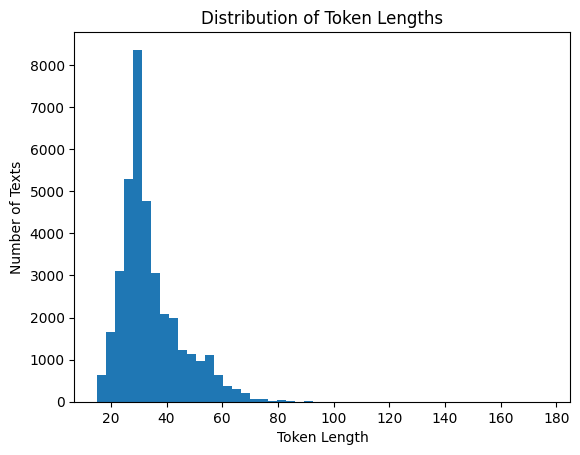

In [13]:
# Load the BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Analyze the token length distribution
token_lengths = plot_token_length_distribution(X_train, tokenizer, add_special_tokens=True, bins=50)


In [14]:
# Tokenize the data and convert labels
train_encodings, val_encodings, test_encodings, train_labels, val_labels, test_labels = tokenize_and_convert_labels(
    X_train, X_val, X_test, y_train, y_val, y_test, model_name='bert-base-uncased', max_length=64
)

In [15]:
# Create the datasets
train_dataset = MetaDescriptionDataset(train_encodings, train_labels)
val_dataset = MetaDescriptionDataset(val_encodings, val_labels)
test_dataset = MetaDescriptionDataset(test_encodings, test_labels)


#### Set paths 

- mount your drive and set paths to store logs, evaluation metrics and model checkpoints

In [16]:
# define paths to store the model & logs
output_dir_ = '/content/drive/MyDrive/files/bert_fine_tuned_model'
logging_dir_ = '/content/drive/MyDrive/files/bert_training_logs'
path_to_save_eval_results = '/content/drive/MyDrive/files/bert_eval_results'

### Best model

- 'bert-base-uncased'
- optimizer AdamW

In [30]:
# model 2

model_version = 'v2'
# Initialize the model
model = initialize_model(model_name='bert-base-uncased', num_labels=len(np.unique(y)))

training_args = TrainingArguments(
    output_dir=output_dir_,
    num_train_epochs=4,  # Use 4 epochs as specified
    per_device_train_batch_size=64,
    per_device_eval_batch_size=64,
    learning_rate=3e-5,  # Lower learning rate
    warmup_steps=500,
    weight_decay=0.02,  # Increased weight decay
    logging_dir=logging_dir_,
    logging_steps=10,
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="precision",  # Use precision for early stopping
    greater_is_better=True,  # Lower validation loss is better
    save_total_limit=3,
    lr_scheduler_type="linear"  # Use linear scheduler with warmup
)


# Define the optimizer
optimizer = AdamW(model.parameters(), lr=3e-5, weight_decay=0.02)

# Total number of training steps
total_steps = len(train_dataset) // training_args.per_device_train_batch_size * training_args.num_train_epochs

# Define the scheduler
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=500,  # Warmup steps
    num_training_steps=total_steps  # Total steps
)


trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
    optimizers=(optimizer, scheduler)  # Pass the optimizer and scheduler here
)

# Train the model
train_output = trainer.train()
# Access the components of the TrainOutput
print(f"Total training steps: {train_output.global_step}")
print(f"Final training loss: {train_output.training_loss}")
# After training, plot the losses

# plot_loss(history)

# evaluate
eval_df = evaluate_and_save_results(trainer, test_dataset, path_to_save_eval_results, filename=f'{model_version}_eval_results.csv')

# Display the DataFrame
eval_df

# Get predictions on the test dataset
predictions, labels, metrics = trainer.predict(test_dataset)

# Print the predictions and metrics
# print(predictions)
print(metrics)

# Convert logits to predicted class labels
predicted_labels = np.argmax(predictions, axis=1)

# evaluate
metrics = evaluate_model_performance(labels, predicted_labels)


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.484700,0.422241,0.886329,0.891244,0.886329,0.887010
2,0.428000,0.374676,0.897281,0.898411,0.897281,0.897122
3,0.179500,0.369747,0.902316,0.903591,0.902316,0.902568
4,0.098400,0.383378,0.905337,0.905498,0.905337,0.905306


Total training steps: 2320
Final training loss: 0.4809099322506066


Evaluation results saved to v2_eval_results.csv
{'test_loss': 0.4320617914199829, 'test_accuracy': 0.8950283196979232, 'test_precision': 0.8948877421597973, 'test_recall': 0.8950283196979232, 'test_f1': 0.8949175308894523, 'test_runtime': 25.6409, 'test_samples_per_second': 309.857, 'test_steps_per_second': 4.875}
Accuracy: 0.8950283196979232
Precision: 0.8948877421597973
Recall: 0.8950283196979232
F1 Score: 0.8949175308894523
Confusion Matrix:
[[614   6   6   9  17   2   3  13  16   6   5   7   7]
 [  8 255   5   9   0   4   5   4   5   1   6   3   3]
 [  2   1 525  11   4   5   3   4   5   2   4   2   3]
 [  8  12   9 699   1   7   6   2   8   1   7  13   2]
 [ 18   3   1   3 529   1   3   8   5   1   6   5  12]
 [  4   3   5   4   2 717   4   1   3   1   3  15   2]
 [  1   6   4   3   0   2 763   2   9   0   5   8   6]
 [  8   2   4   0   4   2   2 305   3  13   1   2  13]
 [  9   3   2  10   5   8  13   2 537   2  19  20  11]
 [ 12   2   1   4   7   0   2   4   1 254   1   2   1]
 

In [43]:
## Save AVG metrics & Per class 
## Save confusion matrix

save_metrics_to_csv(metrics, average_metrics_file=f'{path_to_save_eval_results}/{model_version}_average_metrics.csv', class_metrics_file=f'{path_to_save_eval_results}/{model_version}_class_metrics.csv')

# Save the confusion matrix to CSV
conf_matrix_df = pd.DataFrame(metrics['confusion_matrix'])
conf_matrix_df.to_csv(f'{path_to_save_eval_results}/{model_version}_confusion_matrix.csv', index=False, header=False)
print(f'{path_to_save_eval_results}/{model_version}_confusion_matrix.csv')

Average metrics saved to /content/drive/MyDrive/files/bert_eval_results/v2_average_metrics.csv
Class-wise metrics saved to /content/drive/MyDrive/files/bert_eval_results/v2_class_metrics.csv
dict_keys(['precision', 'recall', 'f1-score', 'support'])
/content/drive/MyDrive/files/bert_eval_results/v2_confusion_matrix.csv


#### Plot confusion matrix

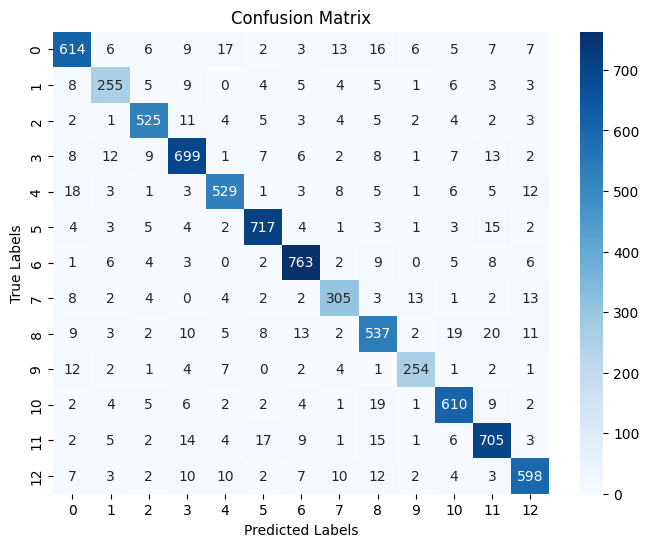

In [44]:

# You can access the individual metrics if needed
accuracy = metrics['accuracy']
conf_matrix = metrics['confusion_matrix']

# Assuming 'conf_matrix' is your confusion matrix
plot_confusion_matrix(conf_matrix)

# Assuming `labels` is your actual labels and `predicted_labels` is your predictions
labels = np.array(labels)  # Actual labels
predicted_labels = np.array(predicted_labels)  # Predicted labels

# Create a DataFrame
actual_vs_predicted = pd.DataFrame({
    'Actual Label': decode_labels(labels, label_encoder),
    'Predicted Label': decode_labels(predicted_labels, label_encoder)
})

# Save the DataFrame to a CSV file
actual_vs_predicted.to_csv(f'{path_to_save_eval_results}/{model_version}_actual_vs_predicted.csv', index=False)

In [46]:
## Label mapping to help with interpretation

label_mapping

{'commercial services & supplies': 0,
 'consumer discretionary': 1,
 'consumer staples': 2,
 'corporate services': 3,
 'energy & utilities': 4,
 'financials': 5,
 'healthcare': 6,
 'industrials': 7,
 'information technology': 8,
 'materials': 9,
 'media, marketing & sales': 10,
 'professional services': 11,
 'transportation & logistics': 12}

### Experimentation with Hyperparams

Experiment with 

- Different learning_rate 
- Different weight_decay
- Different batch_sizes  
- metric_for_best_model ("eval_loss"/ "precision")
- 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.486900,0.431367,0.885196,0.890819,0.885196,0.886013
2,0.438400,0.372084,0.897910,0.899323,0.897910,0.897800
3,0.201000,0.367317,0.903575,0.904695,0.903575,0.903835
4,0.125900,0.380210,0.903072,0.903491,0.903072,0.903070


Total training steps: 2320
Final training loss: 0.47646773819779525


Evaluation results saved to v6_eval_results.csv
{'test_loss': 0.41643574833869934, 'test_accuracy': 0.891881686595343, 'test_precision': 0.8926236102891544, 'test_recall': 0.891881686595343, 'test_f1': 0.8920257806801822, 'test_runtime': 25.5663, 'test_samples_per_second': 310.761, 'test_steps_per_second': 4.889}
Accuracy: 0.891881686595343
Precision: 0.8926236102891544
Recall: 0.891881686595343
F1 Score: 0.8920257806801822
Confusion Matrix:
[[623   7   3   9  14   0   4  10  14  10   5   7   5]
 [ 10 252   4   8   0   4   5   6   4   3   6   3   3]
 [  5   1 514  16   4   4   4   3   5   5   5   4   1]
 [  9  11   8 697   2   4   7   2  10   2   9  13   1]
 [ 24   1   1   3 529   1   1   7   4   4   7   5   8]
 [  6   3   5   5   1 707   3   1   4   1   3  19   6]
 [  5   7   4   8   1   2 747   3  13   0   4  10   5]
 [ 12   1   2   0   6   2   2 297   2  19   1   2  13]
 [ 16   0   1   8   6   7  11   2 538   2  20  22   8]
 [ 14   1   1   2   2   0   1   4   1 259   3   3   0]
 [  

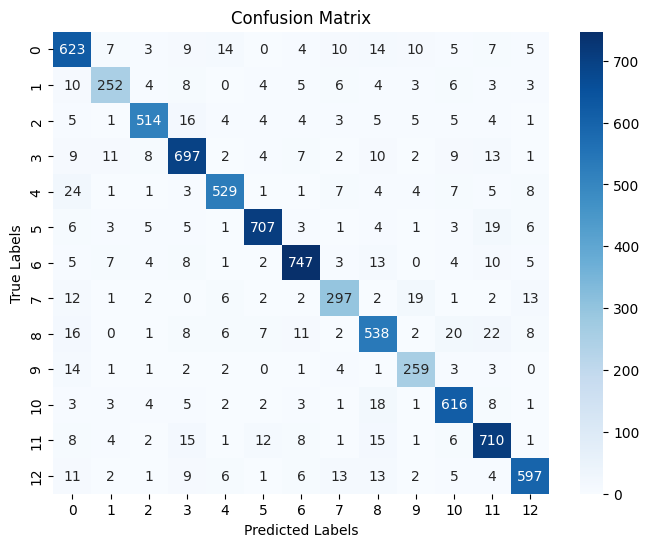

In [21]:
# model 6

model_version = 'v6'
# Initialize the model
model = initialize_model(model_name='bert-base-uncased', num_labels=len(np.unique(y)))

training_args = TrainingArguments(
    output_dir=output_dir_,
    num_train_epochs=4,  # Use 4 epochs as specified
    per_device_train_batch_size=64,
    per_device_eval_batch_size=64,
    learning_rate=3e-5,  # Lower learning rate
    warmup_steps=500,
    weight_decay=0.02,  # Increased weight decay
    logging_dir=logging_dir_,
    logging_steps=10,
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,  # Load the best model (based on validation loss)
    metric_for_best_model="eval_loss",  # Use validation loss to determine the best model
    greater_is_better=False,  # Minimize validation loss # Lower validation loss is better
    save_total_limit=3,
    lr_scheduler_type="linear"  # Use linear scheduler with warmup
)


# Define the optimizer
optimizer = AdamW(model.parameters(), lr=3e-5, weight_decay=0.02)

# Total number of training steps
total_steps = len(train_dataset) // training_args.per_device_train_batch_size * training_args.num_train_epochs

# Define the scheduler
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=500,  # Warmup steps
    num_training_steps=total_steps  # Total steps
)

# Initialize the Trainer with early stopping
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
    optimizers=(optimizer, scheduler),
    callbacks=[EarlyStoppingCallback(early_stopping_patience=1)]  # Stop after 1 epoch with no improvement
)

# Train the model
train_output = trainer.train()
# Access the components of the TrainOutput
print(f"Total training steps: {train_output.global_step}")
print(f"Final training loss: {train_output.training_loss}")
# After training, plot the losses

# plot_loss(history)

# evaluate
eval_df = evaluate_and_save_results(trainer, test_dataset, path_to_save_eval_results, filename=f'{model_version}_eval_results.csv')

# Display the DataFrame
eval_df

# Get predictions on the test dataset
predictions, labels, metrics = trainer.predict(test_dataset)

# Print the predictions and metrics
# print(predictions)
print(metrics)

# Convert logits to predicted class labels
predicted_labels = np.argmax(predictions, axis=1)

# evaluate
metrics = evaluate_model_performance(labels, predicted_labels)

# You can access the individual metrics if needed
accuracy = metrics['accuracy']
conf_matrix = metrics['confusion_matrix']

# Assuming 'conf_matrix' is your confusion matrix
plot_confusion_matrix(conf_matrix)

# Assuming `labels` is your actual labels and `predicted_labels` is your predictions
labels = np.array(labels)  # Actual labels
predicted_labels = np.array(predicted_labels)  # Predicted labels

# Create a DataFrame
actual_vs_predicted = pd.DataFrame({
    'Actual Label': labels,
    'Predicted Label': predicted_labels
})

# Save the DataFrame to a CSV file
actual_vs_predicted.to_csv(f'{path_to_save_eval_results}/{model_version}_actual_vs_predicted.csv', index=False)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.411000,0.387212,0.893379,0.895624,0.893379,0.893740
2,0.423100,0.416608,0.892497,0.893925,0.892497,0.892277


Total training steps: 4634
Final training loss: 0.5004312420230926


Evaluation results saved to v5_eval_results.csv
{'test_loss': 0.4287073016166687, 'test_accuracy': 0.889490245437382, 'test_precision': 0.8911721169033173, 'test_recall': 0.889490245437382, 'test_f1': 0.8898057319922452, 'test_runtime': 25.7428, 'test_samples_per_second': 308.63, 'test_steps_per_second': 4.856}
Accuracy: 0.889490245437382
Precision: 0.8911721169033173
Recall: 0.889490245437382
F1 Score: 0.8898057319922452
Confusion Matrix:
[[619   7   5  12  18   1   4   8  18   9   3   2   5]
 [  8 250   6  12   1   5   6   5   3   1   3   5   3]
 [  4   1 513  16   8   3   4   6   5   4   4   3   0]
 [  8  15   7 692   4   4  11   1  11   1   6  12   3]
 [ 19   2   1   6 543   0   1   3   7   2   4   2   5]
 [  4   5   2   6   5 704   4   2   7   0   4  18   3]
 [  4   4   3   7   2   4 760   1   9   0   2   9   4]
 [  7   1   2   1  10   2   5 295   5  18   0   0  13]
 [ 12   0   1   9   6   6  11   1 571   1   7  12   4]
 [ 17   1   0   1   5   0   1   5   4 253   2   2   0]
 [  2 

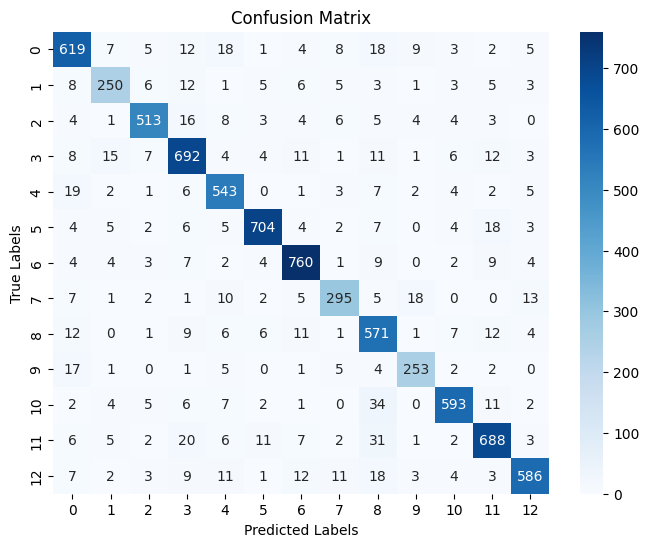

In [20]:
# model 5

from transformers import Trainer, TrainingArguments, EarlyStoppingCallback

model_version = 'v5'

# Initialize the model
model = initialize_model(model_name='bert-base-uncased', num_labels=len(np.unique(y)))


# Set up training arguments
training_args = TrainingArguments(
    output_dir=output_dir_,
    num_train_epochs=5,  # Maximum epochs; early stopping will potentially stop before this
    per_device_train_batch_size=16,
    per_device_eval_batch_size=64,
    warmup_steps=500,
    weight_decay=0.03,
    logging_dir=logging_dir_,
    logging_steps=10,
    eval_strategy="epoch",  # Evaluate at the end of each epoch
    save_strategy="epoch",  # Save model at the end of each epoch
    load_best_model_at_end=True,  # Load the best model (based on validation loss)
    metric_for_best_model="eval_loss",  # Use validation loss to determine the best model
    greater_is_better=False,  # Minimize validation loss
    save_total_limit=3,
)

# Define the optimizer
optimizer = AdamW(model.parameters(), lr=3e-5, weight_decay=0.03)

# Total number of training steps
total_steps = len(train_dataset) // training_args.per_device_train_batch_size * training_args.num_train_epochs

# Define the scheduler
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=500,  # Warmup steps
    num_training_steps=total_steps  # Total steps
)

# Initialize the Trainer with early stopping
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
    optimizers=(optimizer, scheduler),
    callbacks=[EarlyStoppingCallback(early_stopping_patience=1)]  # Stop after 1 epoch with no improvement
)

# Train the model
train_output = trainer.train()

# Access the components of the TrainOutput
print(f"Total training steps: {train_output.global_step}")
print(f"Final training loss: {train_output.training_loss}")
# After training, plot the losses

# plot_loss(history)

# evaluate
eval_df = evaluate_and_save_results(trainer, test_dataset, path_to_save_eval_results, filename=f'{model_version}_eval_results.csv')

# Display the DataFrame
eval_df

# Get predictions on the test dataset
predictions, labels, metrics = trainer.predict(test_dataset)

# Print the predictions and metrics
# print(predictions)
print(metrics)

# Convert logits to predicted class labels
predicted_labels = np.argmax(predictions, axis=1)

# evaluate
metrics = evaluate_model_performance(labels, predicted_labels)

# You can access the individual metrics if needed
accuracy = metrics['accuracy']
conf_matrix = metrics['confusion_matrix']

# Assuming 'conf_matrix' is your confusion matrix
plot_confusion_matrix(conf_matrix)

# Assuming `labels` is your actual labels and `predicted_labels` is your predictions
labels = np.array(labels)  # Actual labels
predicted_labels = np.array(predicted_labels)  # Predicted labels

# Create a DataFrame
actual_vs_predicted = pd.DataFrame({
    'Actual Label': labels,
    'Predicted Label': predicted_labels
})

# Save the DataFrame to a CSV file
actual_vs_predicted.to_csv(f'{path_to_save_eval_results}/{model_version}_actual_vs_predicted.csv', index=False)



Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.442700,0.424092,0.885574,0.889380,0.885574,0.886229
2,0.484300,0.453144,0.889099,0.890206,0.889099,0.889037


Total training steps: 4634
Final training loss: 0.49776485015669925


Evaluation results saved to v4_eval_results.csv
{'test_loss': 0.45894116163253784, 'test_accuracy': 0.8820641913152927, 'test_precision': 0.8851729185538295, 'test_recall': 0.8820641913152927, 'test_f1': 0.8828222179569556, 'test_runtime': 25.6918, 'test_samples_per_second': 309.242, 'test_steps_per_second': 4.865}
Accuracy: 0.8820641913152927
Precision: 0.8851729185538295
Recall: 0.8820641913152927
F1 Score: 0.8828222179569556
Confusion Matrix:
[[628   7   5   9  10   0   3   9  17  10   3   4   6]
 [  7 261   5   6   0   5   6   6   3   0   2   3   4]
 [  9   1 505  20   6   4   4   4   5   6   3   3   1]
 [ 12  12   5 676   6  10  12   0  17   3   8  11   3]
 [ 26   1   1   6 533   0   0   5   9   4   3   2   5]
 [  4   5   2   8   4 699   4   4   9   1   1  17   6]
 [  6   5   4  10   0   3 751   1  13   1   3   9   3]
 [ 11   1   2   1   4   1   3 293   5  27   0   0  11]
 [ 15   1   0   9   6   4  10   4 564   3   7  13   5]
 [ 20   2   0   1   4   0   0   3   3 253   1   2   2]


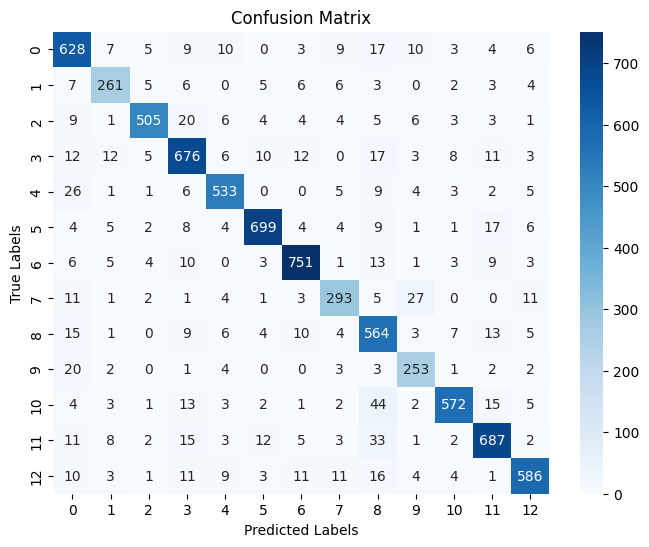

In [19]:
# model 4

from transformers import Trainer, TrainingArguments, EarlyStoppingCallback

model_version = 'v4'

# Initialize the model
model = initialize_model(model_name='bert-base-uncased', num_labels=len(np.unique(y)))


# Set up training arguments
training_args = TrainingArguments(
    output_dir=output_dir_,
    num_train_epochs=5,  # Maximum epochs; early stopping will potentially stop before this
    per_device_train_batch_size=16,
    per_device_eval_batch_size=64,
    warmup_steps=500,
    weight_decay=0.02,
    logging_dir=logging_dir_,
    logging_steps=10,
    eval_strategy="epoch",  # Evaluate at the end of each epoch
    save_strategy="epoch",  # Save model at the end of each epoch
    load_best_model_at_end=True,  # Load the best model (based on validation loss)
    metric_for_best_model="eval_loss",  # Use validation loss to determine the best model
    greater_is_better=False,  # Minimize validation loss
    save_total_limit=3,
)

# Define the optimizer
optimizer = AdamW(model.parameters(), lr=4e-5, weight_decay=0.02)

# Total number of training steps
total_steps = len(train_dataset) // training_args.per_device_train_batch_size * training_args.num_train_epochs

# Define the scheduler
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=500,  # Warmup steps
    num_training_steps=total_steps  # Total steps
)

# Initialize the Trainer with early stopping
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=1)]  # Stop after 1 epoch with no improvement
)

# Train the model
train_output = trainer.train()
# Access the components of the TrainOutput
print(f"Total training steps: {train_output.global_step}")
print(f"Final training loss: {train_output.training_loss}")
# After training, plot the losses

# plot_loss(history)

# evaluate
eval_df = evaluate_and_save_results(trainer, test_dataset, path_to_save_eval_results, filename=f'{model_version}_eval_results.csv')

# Display the DataFrame
eval_df

# Get predictions on the test dataset
predictions, labels, metrics = trainer.predict(test_dataset)

# Print the predictions and metrics
# print(predictions)
print(metrics)

# Convert logits to predicted class labels
predicted_labels = np.argmax(predictions, axis=1)

# evaluate
metrics = evaluate_model_performance(labels, predicted_labels)

# You can access the individual metrics if needed
accuracy = metrics['accuracy']
conf_matrix = metrics['confusion_matrix']

# Assuming 'conf_matrix' is your confusion matrix
plot_confusion_matrix(conf_matrix)

# Assuming `labels` is your actual labels and `predicted_labels` is your predictions
labels = np.array(labels)  # Actual labels
predicted_labels = np.array(predicted_labels)  # Predicted labels

# Create a DataFrame
actual_vs_predicted = pd.DataFrame({
    'Actual Label': labels,
    'Predicted Label': predicted_labels
})

# Save the DataFrame to a CSV file
actual_vs_predicted.to_csv(f'{path_to_save_eval_results}/{model_version}_actual_vs_predicted.csv', index=False)


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.457700,0.405310,0.893379,0.894454,0.893379,0.893569
2,0.480300,0.445112,0.887588,0.889360,0.887588,0.887641


Total training steps: 4634
Final training loss: 0.4981259664791537


Evaluation results saved to v3_eval_results.csv
{'test_loss': 0.4414701759815216, 'test_accuracy': 0.8893643801132788, 'test_precision': 0.8904722630310674, 'test_recall': 0.8893643801132788, 'test_f1': 0.8896735424443855, 'test_runtime': 25.728, 'test_samples_per_second': 308.807, 'test_steps_per_second': 4.859}
Accuracy: 0.8893643801132788
Precision: 0.8904722630310674
Recall: 0.8893643801132788
F1 Score: 0.8896735424443855
Confusion Matrix:
[[623   6   5   6   9   2   3  11  20   9   4   7   6]
 [  7 259   4   8   0   4   5   6   2   1   4   3   5]
 [  3   2 520  13   4   4   2   5   5   7   1   4   1]
 [ 14  11   8 675   6   5   9   2  12   2   5  21   5]
 [ 22   1   0   6 537   0   0   5   8   4   4   2   6]
 [  3   7   4   3   5 706   3   3   5   0   3  17   5]
 [  3   3   3   9   1   5 759   1  11   0   3   6   5]
 [  9   1   3   0   9   0   2 303   4  14   0   2  12]
 [ 13   1   1   9   5   5  13   5 556   1   8  14  10]
 [ 17   2   1   1   5   0   2   8   4 243   2   1   5]
 [

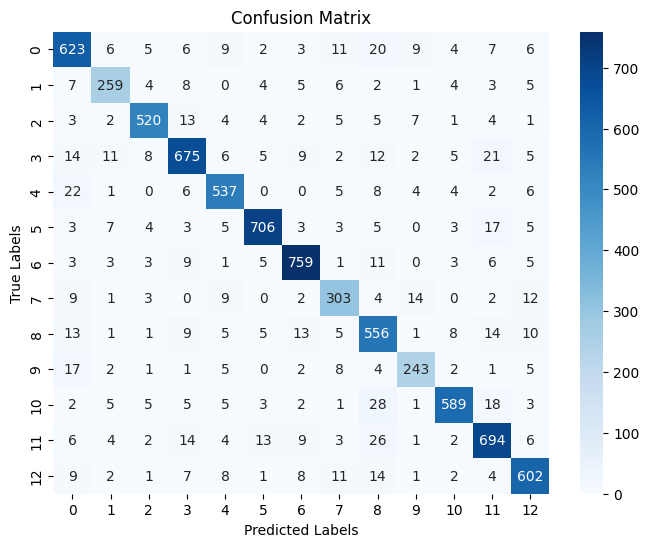

In [18]:
# model 3

from transformers import Trainer, TrainingArguments, EarlyStoppingCallback

model_version = 'v3'

# Initialize the model
model = initialize_model(model_name='bert-base-uncased', num_labels=len(np.unique(y)))


# Set up training arguments
training_args = TrainingArguments(
    output_dir=output_dir_,
    num_train_epochs=5,  # Maximum epochs; early stopping will potentially stop before this
    per_device_train_batch_size=16,
    per_device_eval_batch_size=64,
    warmup_steps=500,
    weight_decay=0.02,
    logging_dir=logging_dir_,
    logging_steps=10,
    eval_strategy="epoch",  # Evaluate at the end of each epoch
    save_strategy="epoch",  # Save model at the end of each epoch
    load_best_model_at_end=True,  # Load the best model (based on validation loss)
    metric_for_best_model="eval_loss",  # Use validation loss to determine the best model
    greater_is_better=False,  # Minimize validation loss
    save_total_limit=3,
)

# Define the optimizer
optimizer = AdamW(model.parameters(), lr=2e-5, weight_decay=0.02)

# Total number of training steps
total_steps = len(train_dataset) // training_args.per_device_train_batch_size * training_args.num_train_epochs

# Define the scheduler
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=500,  # Warmup steps
    num_training_steps=total_steps  # Total steps
)

# Initialize the Trainer with early stopping
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=1)]  # Stop after 1 epoch with no improvement
)

# Train the model
train_output = trainer.train()
# Access the components of the TrainOutput
print(f"Total training steps: {train_output.global_step}")
print(f"Final training loss: {train_output.training_loss}")
# After training, plot the losses

# plot_loss(history)

# evaluate
eval_df = evaluate_and_save_results(trainer, test_dataset, path_to_save_eval_results, filename=f'{model_version}_eval_results.csv')

# Display the DataFrame
eval_df

# Get predictions on the test dataset
predictions, labels, metrics = trainer.predict(test_dataset)

# Print the predictions and metrics
# print(predictions)
print(metrics)

# Convert logits to predicted class labels
predicted_labels = np.argmax(predictions, axis=1)

# evaluate
metrics = evaluate_model_performance(labels, predicted_labels)

# You can access the individual metrics if needed
accuracy = metrics['accuracy']
conf_matrix = metrics['confusion_matrix']

# Assuming 'conf_matrix' is your confusion matrix
plot_confusion_matrix(conf_matrix)

# Assuming `labels` is your actual labels and `predicted_labels` is your predictions
labels = np.array(labels)  # Actual labels
predicted_labels = np.array(predicted_labels)  # Predicted labels

# Create a DataFrame
actual_vs_predicted = pd.DataFrame({
    'Actual Label': labels,
    'Predicted Label': predicted_labels
})

# Save the DataFrame to a CSV file
actual_vs_predicted.to_csv(f'{path_to_save_eval_results}/{model_version}_actual_vs_predicted.csv', index=False)


#### model 1: overfitting indications

In [12]:
# model 1  - Overfitting

# set paths

# Initialize the model
model = initialize_model(model_name='bert-base-uncased', num_labels=len(np.unique(y)))

training_args = TrainingArguments(
    output_dir= output_dir_,
    num_train_epochs=5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=64,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir=logging_dir_,
    logging_steps=10,
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="precision",
    greater_is_better=True,
    save_total_limit=3,
)

# Add the callback to the Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

# Train the model
trainer.train()

# After training, plot the losses
# plot_loss(history)

# evaluate
eval_df = evaluate_and_save_results(trainer, test_dataset, path_to_save_eval_results, filename='eval_results.csv')

# Display the DataFrame
eval_df

# Get predictions on the test dataset
predictions, labels, metrics = trainer.predict(test_dataset)

# Print the predictions and metrics
# print(predictions)
print(metrics)

# Convert logits to predicted class labels
predicted_labels = np.argmax(predictions, axis=1)

# evaluate
metrics = evaluate_model_performance(labels, predicted_labels)

# You can access the individual metrics if needed
accuracy = metrics['accuracy']
conf_matrix = metrics['confusion_matrix']

# Assuming 'conf_matrix' is your confusion matrix
plot_confusion_matrix(conf_matrix)

# Assuming `labels` is your actual labels and `predicted_labels` is your predictions
labels = np.array(labels)  # Actual labels
predicted_labels = np.array(predicted_labels)  # Predicted labels

# Create a DataFrame
actual_vs_predicted = pd.DataFrame({
    'Actual Label': labels,
    'Predicted Label': predicted_labels
})

# Save the DataFrame to a CSV file
misclassified_samples = actual_vs_predicted[actual_vs_predicted['Predicted Label'] != actual_vs_predicted['Actual Label']]
misclassified_samples


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1494: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.651500,0.439653,0.883812,0.885612,0.883812,0.884263
2,0.285400,0.442200,0.890232,0.890595,0.890232,0.890006
3,0.193400,0.522953,0.890483,0.890791,0.890483,0.890122
4,0.064000,0.579721,0.894637,0.895090,0.894637,0.894627
5,0.052700,0.626374,0.895141,0.895277,0.895141,0.895128


TrainOutput(global_step=11585, training_loss=0.27608143628732074, metrics={'train_runtime': 2423.9419, 'train_samples_per_second': 76.47, 'train_steps_per_second': 4.779, 'total_flos': 6096885249423360.0, 'train_loss': 0.27608143628732074, 'epoch': 5.0})